# Chapter 9. Additive models, Trees, and Related methods

## 9.1: Generalized additive models

In [73]:
# Import dependent packages
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
import scipy as sp
from scipy import linalg
plt.style.use('seaborn')
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from IPython.display import Image
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.ensemble import BaggingRegressor
from pygam import LinearGAM, s, f
from pygam.datasets import wage
from pygam import LogisticGAM


In [2]:
### Function takes two feature transform methods: normalization and MiniMaxScale
def feature_prerpocess(data, form = 'normal'):
    if form == "normal":
        new_data = scale(data)
    elif form == "MinMax":
        new_data = minmax_scale(data)
    return pd.DataFrame(new_data)

In the regression setting, a generalized additive model has the form:

\begin{equation}
E(Y|X_1,X_2,...,X_p) = \alpha + f_1(X_1)+ f_2(X_2)+...+ f_p(X_p)
\end{equation}

where $f_p(X_p)$ is a smooth, non-parametric function. Mainly there are three classes of smooth functions used for GAM:

1. Local regression
2. Smoothing splines
3. Regression splines

#### 1) GAM with local regression at target point $x_{j0}$:

\begin{equation}
E(Y_i|X_{10},X_{20},...,X_{p0}) = \alpha + f_1(X_{10})+ f_2(X_{20})+...+ f_p(X_{p0})
\end{equation}

where locallly weighted regression solves a separate weighted least squares problem at each target point $x_{j0}$:
\begin{equation}
min_{\alpha(x_{j0}), \beta(x_{j0})} = \sum_{i=1}^{N} K_{\lambda}(x_{j0},x_{ji})[y_i-\alpha(x_{j0})- \beta(x_{j0})x_{ji}]^2
\end{equation}

$K_{\lambda}(x_{j0},x_{ji}) = D(\frac{|x_{ji}-x_{j0}|}{\lambda})$

#### 2) GAM with smoothing spline:

In smoothing spline we evaluate the smooth function by minimizing the penalized sum of squares:

\begin{equation}
\sum_{i=1}^{N} (y_i-f(x_i))^2 + \lambda \int f^{//}(x_i))^2 dx	
\end{equation}

where $\lambda \int f^{//}(x_i))^2 dx$ is the penalty term and it imposes smoothness (i.e., penalizes wiggliness).

#### 3) GAM with regression splines:

Regression splines involves fitting separate low-degree polynomials over different regions of $X$. For example, a piecewise cubic polynomial works by fitting a cubic regression mode:

\begin{equation}
y_i = \beta_0 + \beta_1x_i + \beta_2x_i^2 + \beta_3x_i^3 + \epsilon_i
\end{equation}

where the coefficients $\beta_0, \beta_1, \beta_2, and \beta_3$ differ in different parts of the range of $X$. The points where the coefficients change are called $knots$.

A cubic spline with $K$ knots can be modeled as:

\begin{equation}
y_i = \beta_0 + \beta_1b_1(x_i) + \beta_2b_2(x_i) + ... + \beta_{K+3}b_{K+3}(x_i) + \epsilon_i
\end{equation}

for an appropriate choice of basis functions $b_1, b_2, ..., b_{K+3}$


#### 1. GAM regression with PyGAM package

We will use "Seoul Bike" dataset, it can can be downloaded:
* <a href="https://www.kaggle.com/c/seoul-bike-rental-prediction/data">Seoul Bike Rental Prediction
    
The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information. The target variable is a bike count required at each hour.

In [5]:
#Download data 
Seoul_bike = pd.read_csv('SeoulBikeData.csv', sep=',', encoding= 'unicode_escape')
Seoul_bike

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


For simplicity purposes, we keep only 3 features. 

In [58]:
X_matrix = Seoul_bike.iloc[:100, 3:6]
y_var = Seoul_bike.iloc[:100, 1:2]

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_var, test_size=0.30)

In [59]:
## model
gam_model = LinearGAM(s(0) + s(1) + s(2))
gam_model.gridsearch(np.asarray(X_train), np.asarray(y_train))
gam_model.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     16.3298
Link Function:                     IdentityLink Log Likelihood:                                  -746.4176
Number of Samples:                           70 AIC:                                             1527.4947
                                                AICc:                                              1539.79
                                                GCV:                                            28834.5258
                                                Scale:                                          17054.1234
                                                Pseudo R-Squared:                                   0.6941
Feature Function                  Lam

In modeling GAM we can decompose and inspect the contribution of each feature to the overall prediction.
This can be done using partial dependence functions.

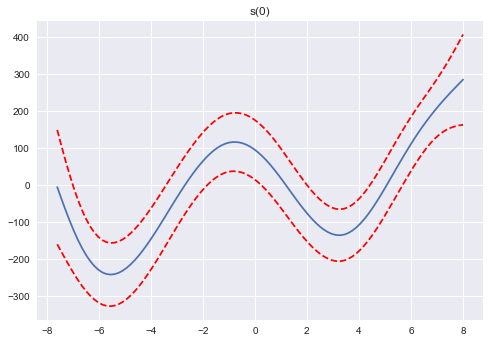

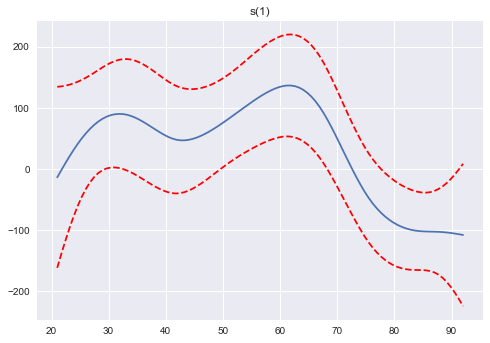

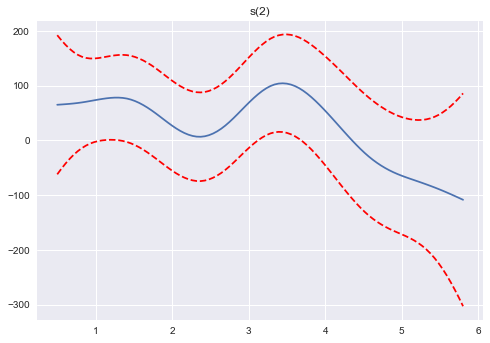

In [60]:
for i, term in enumerate(gam_model.terms):
    if term.isintercept:
        continue
    XX = gam_model.generate_X_grid(term=i)
    pdep, confi = gam_model.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

#### 2.. GAM classififcation with PyGAM package

We will use "Audit" dataset, it can be downloaded:
* <a href="https://archive.ics.uci.edu/ml/datasets/Audit+Data#">Audit Dataset
    
The dataset contains 777 different firms that are collected from six distinct sectors. The information about the sectors and the counts of firms are listed respectively as Irrigation (114), Public Health (77), Buildings and Roads (82), Forest (70), Corporate (47), Animal Husbandry (95), Communication (1), Electrical (4), Land (5), Science and Technology (3), Tourism (1), Fisheries (41), Industries (37), Agriculture (200). Many risk factors are examined from various areas like past records of audit office, audit-paras, environmental conditions reports, firm reputation summary, on-going issues report, profit-value records, loss-value records, follow-up reports etc. Thus we build a classification model that can predict the fraudulent firm on the basis the present and historical risk factors.

In [70]:
#Download data 
Audit = pd.read_csv('audit_risk.csv', sep=',', encoding= 'unicode_escape')
Audit.describe()

,Sector_score,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,Score_B.1,...,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
count,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,...,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.0,776.000000,776.000000
mean,20.184536,2.450194,0.351289,1.351029,10.799988,0.313144,6.334008,13.218481,5.067655,0.223711,...,0.519072,0.104381,0.216753,0.053608,2.702577,17.680612,0.572680,0.5,7.168158,0.393041
std,24.319017,5.678870,0.174055,3.440447,50.083624,0.169804,30.072845,51.312829,0.264449,0.080352,...,0.290312,0.531031,0.067987,0.305835,0.858923,54.740244,0.444581,0.0,38.667494,0.488741
min,1.850000,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,5.000000,0.200000,...,0.400000,0.000000,0.200000,0.000000,2.000000,1.400000,0.400000,0.5,0.280000,0.000000
25%,2.370000,0.210000,0.200000,0.042000,0.000000,0.200000,0.000000,0.537500,5.000000,0.200000,...,0.400000,0.000000,0.200000,0.000000,2.000000,1.583500,0.400000,0.5,0.316700,0.000000
50%,3.890000,0.875000,0.200000,0.175000,0.405000,0.200000,0.081000,1.370000,5.000000,0.200000,...,0.400000,0.000000,0.200000,0.000000,2.400000,2.214000,0.400000,0.5,0.555600,0.000000
75%,55.570000,2.480000,0.600000,1.488000,4.160000,0.400000,1.840500,7.707500,5.000000,0.200000,...,0.400000,0.000000,0.200000,0.000000,3.250000,10.663500,0.400000,0.5,3.249900,1.000000
max,59.850000,85.000000,0.600000,51.000000,1264.630000,0.600000,758.778000,1268.910000,9.000000,0.600000,...,2.400000,9.000000,0.600000,5.400000,5.200000,801.262000,5.800000,0.5,961.514400,1.000000


Again for simplicity purposes, we keep only 3 features. 

In [77]:
X_matrix = Audit.iloc[:100, 3:6]
y_var = Audit.iloc[:100, -1] 

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_var, test_size=0.30)

In [81]:
X_matrix

,Score_A,Risk_A,PARA_B
0,0.6,2.508,2.50
1,0.2,0.000,4.83
2,0.2,0.102,0.23
3,0.2,0.000,10.80
4,0.2,0.000,0.08
...,...,...,...
95,0.2,0.000,0.08
96,0.4,0.476,12.88
97,0.2,0.000,2.72
98,0.2,0.000,1.66


In [78]:
## model
gam_model = LogisticGAM(s(0) + s(1) + s(2))
gam_model.gridsearch(np.asarray(X_train), np.asarray(y_train))
gam_model.summary()

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      4.0215
Link Function:                        LogitLink Log Likelihood:                                   -21.5145
Number of Samples:                           70 AIC:                                               51.0719
                                                AICc:                                              52.0171
                                                UBRE:                                               2.7756
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.5433
Feature Function                  Lam

In [84]:
# Accuracy of the training model
print("Accuracy: {} ".format(gam_model.accuracy(X_train, y_train)))

Accuracy: 0.8714285714285714 
